# Imports and Setting Seed


In [7]:
#For the use of google colab. Connects to google drive, which acts as storage for loading files, data, and models. Comment this out if not using google colab.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
#Also for use of google colab. Imports packages that google colab does not have preinstalled.
!pip3 install segmentation_models_pytorch
!pip3 install warmup_scheduler
!pip3 install pyimagesearch

ERROR: Could not find a version that satisfies the requirement pyimagesearch (from versions: none)
ERROR: No matching distribution found for pyimagesearch


In [9]:
#Import packages

import torch.utils.data as Data
import torch
import segmentation_models_pytorch as smp
import segmentation_models_pytorch.losses as smp_losses
import segmentation_models_pytorch.utils as smp_utils
from torchsummary import summary
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import cv2
import datetime
import random
import sys
from torch.optim.lr_scheduler import StepLR
from warmup_scheduler import GradualWarmupScheduler
from copy import deepcopy
import torchvision.utils as vutils
import ssl
from torch.nn.functional import relu
import pickle

In [10]:
#Define GPU use
torch.set_num_threads(6)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#Define set seed

seed_cus = 1

random.seed(seed_cus)
np.random.seed(seed_cus)
torch.manual_seed(seed_cus)
torch.cuda.manual_seed(seed_cus)
torch.cuda.manual_seed_all(seed_cus)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(seed_cus)

# Load Data

In [11]:
#Define datset class

import torch.utils.data as Data
class My_Dataset(Data.Dataset):
    def __init__(self, LGE_dir, Cine_dir, mask_dir, transform1=None,transform2=None):
        super().__init__()

        #Set paths to the Cine, LGE, and mask directory
        self.LGE_dir = LGE_dir
        self.mask_dir = mask_dir
        self.Cine_dir = Cine_dir

        #Get a list of all the files in the directories
        self.LGE_list = os.listdir(self.LGE_dir)
        self.mask_list = os.listdir(self.mask_dir)
        self.Cine_list = os.listdir(self.Cine_dir)



        #Intialize transforms
        self.transform1 = transform1
        self.transform2 = transform2


    def __getitem__(self, index):

        #Define names for all files using the same LGE base
        LGE_name = self.LGE_list[index]
        mask_name = self.LGE_list[index].split('.')[0] + "_0000.nii.png"
        Cine_name = self.LGE_list[index].split('.')[0] + "_0000.nii.tiff"

        if LGE_name.endswith('.png'):

            #Load LGE, mask, and Cine images
            LGE = cv2.imread(os.path.join(self.LGE_dir,LGE_name))
            mask= cv2.imread(os.path.join(self.mask_dir,mask_name))
            Cine_tuple = cv2.imreadmulti(os.path.join(self.Cine_dir,Cine_name), flags = cv2.IMREAD_COLOR)

            #Cine immultiread returns a tuple of length 2, with only the second value being the list of iamges
            Cine_list = Cine_tuple[1]

            #Get the first image from the list and perform all necessary operations
            first_cine = Cine_list[0]
            tuned = first_cine/[255.0]
            tuned = cv2.resize(tuned,(224,224))
            tuned = tuned.astype(np.float32)
            tuned = self.transform1(tuned)

            combined_cines = tuned.permute(1,2,0)

            #Because the first image was created, now in the for loop the other images can all just be stacked onto the first one with an end shape of (90, 224, 224)
            #The channel number is 90 because each image has 3 channels, and there are 30 images, so when stacked channel wise the function returns an output with 3*30 = 90 channels
            for i in range(len(Cine_list)-1):
              Cine = Cine_list[i+1]
              Cine = Cine/[255.0]
              Cine = cv2.resize(Cine,(224,224))
              Cine = Cine.astype(np.float32)
              Cine = self.transform1(Cine)

              combined_cines = np.dstack((combined_cines, Cine.permute(1,2,0)))

            #After creating the stacked images, flip them
            #This was to fix an error with the code that flipped the images(this is most likely due to an incorrect permutation earlier)
            combined_cines = torch.from_numpy(combined_cines)
            combined_cines = torch.swapaxes(combined_cines, 0, 2)

            combined_cines = torch.flip(torchvision.transforms.functional.rotate(combined_cines, 270), [2])




            #Perform necessary operations on LGE and masks
            LGE = LGE/[255.0]
            LABmask = mask/[1.0]


            LGE = cv2.resize(LGE,(224,224))
            LABmask = cv2.resize(LABmask,(224,224))


            LGE = LGE.astype(np.float32)
            LABmask = LABmask.astype(np.float32)
            LABmask = LABmask[:,:,0]



            if self.transform1:
              LGE = self.transform1(LGE)
              LABmask = self.transform2(LABmask)


            return LGE, combined_cines, LABmask, LGE_name

    def __len__(self):
        return len(self.LGE_list)


#Define transforms

transforms_img = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
])
transforms_mask = transforms.Compose([
    transforms.ToTensor(),
])

In [12]:
# Define batch size, image paths, and create the dataset

LGE_path = '/content/drive/My Drive/Internship_24_Ryan/Heart/Data/train_val/LGE/'
Cine_path = '/content/drive/My Drive/Internship_24_Ryan/Heart/Data/train_val/Cine/'
mask_path = '/content/drive/My Drive/Internship_24_Ryan/Heart/Data/train_val/masks/'


# PARAMETER TUNING: batch size
batch_size_train = 8
batch_size_val = 8

train_set = My_Dataset(LGE_path, Cine_path, mask_path, transform1=transforms_img,transform2=transforms_mask)

n_train = len(train_set)
split = n_train // 5
a = list(range(n_train))

In [13]:
#Load pickle files with the indices meant for training vs testing

with open('/content/drive/My Drive/Internship_24_Ryan/Heart/Indices/train_indices.pkl', 'rb') as f:
  train_indices = pickle.load(f)

with open('/content/drive/My Drive/Internship_24_Ryan/Heart/Indices/val_indices.pkl', 'rb') as f:
  val_indices = pickle.load(f)

In [14]:
# define fixed seed
random.seed(seed_cus)
# define fixed seed
torch.manual_seed(seed_cus)
torch.cuda.manual_seed(seed_cus)
torch.cuda.manual_seed_all(seed_cus)
indices = random.sample(a, len(a))

#Given a list of indices meant for training, create a Dataloader that will create a training set and batches
#Do the same for validation


train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_indices)

# define fixed seed
torch.manual_seed(seed_cus)
torch.cuda.manual_seed(seed_cus)
torch.cuda.manual_seed_all(seed_cus)

valid_sampler = torch.utils.data.sampler.SubsetRandomSampler(val_indices)

train_loader = Data.DataLoader(
    dataset=train_set,
    sampler=train_sampler,
    num_workers=0,
    batch_size=batch_size_train,
    pin_memory=True,
    worker_init_fn=seed_worker,
    generator=g)
valid_loader = Data.DataLoader(
    dataset=train_set,
    sampler=valid_sampler,
    num_workers=0,
    batch_size=batch_size_val,
    pin_memory=True,
    worker_init_fn=seed_worker,
    generator=g)

# Create Custom U-Net

In [15]:
import json
from pathlib import Path
from typing import Optional, Union
from functools import wraps
from huggingface_hub import (
    PyTorchModelHubMixin,
    ModelCard,
    ModelCardData,
    hf_hub_download,
)


MODEL_CARD = """
---
{{ card_data }}
---
# {{ model_name }} Model Card

Table of Contents:
- [Load trained model](#load-trained-model)
- [Model init parameters](#model-init-parameters)
- [Model metrics](#model-metrics)
- [Dataset](#dataset)

## Load trained model
```python
import segmentation_models_pytorch as smp

model = smp.{{ model_name }}.from_pretrained("{{ save_directory | default("<save-directory-or-repo>", true)}}")
```

## Model init parameters
```python
model_init_params = {{ model_parameters }}
```

## Model metrics
{{ metrics | default("[More Information Needed]", true) }}

## Dataset
Dataset name: {{ dataset | default("[More Information Needed]", true) }}

## More Information
- Library: {{ repo_url | default("[More Information Needed]", true) }}
- Docs: {{ docs_url | default("[More Information Needed]", true) }}

This model has been pushed to the Hub using the [PytorchModelHubMixin](https://huggingface.co/docs/huggingface_hub/package_reference/mixins#huggingface_hub.PyTorchModelHubMixin)
"""


def _format_parameters(parameters: dict):
    params = {k: v for k, v in parameters.items() if not k.startswith("_")}
    params = [
        f'"{k}": {v}' if not isinstance(v, str) else f'"{k}": "{v}"'
        for k, v in params.items()
    ]
    params = ",\n".join([f"    {param}" for param in params])
    params = "{\n" + f"{params}" + "\n}"
    return params


class SMPHubMixin(PyTorchModelHubMixin):
    def generate_model_card(self, *args, **kwargs) -> ModelCard:
        model_parameters_json = _format_parameters(self._hub_mixin_config)
        directory = self._save_directory if hasattr(self, "_save_directory") else None
        repo_id = self._repo_id if hasattr(self, "_repo_id") else None
        repo_or_directory = repo_id if repo_id is not None else directory

        metrics = self._metrics if hasattr(self, "_metrics") else None
        dataset = self._dataset if hasattr(self, "_dataset") else None

        if metrics is not None:
            metrics = json.dumps(metrics, indent=4)
            metrics = f"```json\n{metrics}\n```"

        model_card_data = ModelCardData(
            languages=["python"],
            library_name="segmentation-models-pytorch",
            license="mit",
            tags=["semantic-segmentation", "pytorch", "segmentation-models-pytorch"],
            pipeline_tag="image-segmentation",
        )
        model_card = ModelCard.from_template(
            card_data=model_card_data,
            template_str=MODEL_CARD,
            repo_url="https://github.com/qubvel/segmentation_models.pytorch",
            docs_url="https://smp.readthedocs.io/en/latest/",
            model_parameters=model_parameters_json,
            save_directory=repo_or_directory,
            model_name=self.__class__.__name__,
            metrics=metrics,
            dataset=dataset,
        )
        return model_card

    def _set_attrs_from_kwargs(self, attrs, kwargs):
        for attr in attrs:
            if attr in kwargs:
                setattr(self, f"_{attr}", kwargs.pop(attr))

    def _del_attrs(self, attrs):
        for attr in attrs:
            if hasattr(self, f"_{attr}"):
                delattr(self, f"_{attr}")

    @wraps(PyTorchModelHubMixin.save_pretrained)
    def save_pretrained(
        self, save_directory: Union[str, Path], *args, **kwargs
    ) -> Optional[str]:
        # set additional attributes to be used in generate_model_card
        self._save_directory = save_directory
        self._set_attrs_from_kwargs(["metrics", "dataset"], kwargs)

        # set additional attribute to be used in from_pretrained
        self._hub_mixin_config["_model_class"] = self.__class__.__name__

        try:
            # call the original save_pretrained
            result = super().save_pretrained(save_directory, *args, **kwargs)
        finally:
            # delete the additional attributes
            self._del_attrs(["save_directory", "metrics", "dataset"])
            self._hub_mixin_config.pop("_model_class")

        return result

    @wraps(PyTorchModelHubMixin.push_to_hub)
    def push_to_hub(self, repo_id: str, *args, **kwargs):
        self._repo_id = repo_id
        self._set_attrs_from_kwargs(["metrics", "dataset"], kwargs)
        result = super().push_to_hub(repo_id, *args, **kwargs)
        self._del_attrs(["repo_id", "metrics", "dataset"])
        return result

    @property
    def config(self):
        return self._hub_mixin_config


@wraps(PyTorchModelHubMixin.from_pretrained)
def from_pretrained(pretrained_model_name_or_path: str, *args, **kwargs):
    config_path = hf_hub_download(
        pretrained_model_name_or_path,
        filename="config.json",
        revision=kwargs.get("revision", None),
    )
    with open(config_path, "r") as f:
        config = json.load(f)
    model_class_name = config.pop("_model_class")

    import segmentation_models_pytorch as smp

    model_class = getattr(smp, model_class_name)
    return model_class.from_pretrained(pretrained_model_name_or_path, *args, **kwargs)

def initialize_decoder(module):
    for m in module.modules():
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_uniform_(m.weight, mode="fan_in", nonlinearity="relu")
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

        elif isinstance(m, nn.BatchNorm2d):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)

        elif isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)


def initialize_head(module):
    for m in module.modules():
        if isinstance(m, (nn.Linear, nn.Conv2d)):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

In [16]:
import torch

#This is the only section of the model code that has been custom coded - everything else is just what's needed from the SMP library
class SegmentationModel(torch.nn.Module, SMPHubMixin):
    def initialize(self):

        #Define decoders and segmentation head
        initialize_decoder(self.decoder)
        initialize_head(self.segmentation_head)
        if self.classification_head is not None:
            initialize_head(self.classification_head)



    def check_input_shape(self, x):
        h, w = x.shape[-2:]
        output_stride = self.encoder.output_stride
        if h % output_stride != 0 or w % output_stride != 0:
            new_h = (
                (h // output_stride + 1) * output_stride
                if h % output_stride != 0
                else h
            )
            new_w = (
                (w // output_stride + 1) * output_stride
                if w % output_stride != 0
                else w
            )
            raise RuntimeError(
                f"Wrong input shape height={h}, width={w}. Expected image height and width "
                f"divisible by {output_stride}. Consider pad your images to shape ({new_h}, {new_w})."
            )

    def forward(self, x):
        """Sequentially pass `x` trough model`s encoder, decoder and heads"""
        added_features = []


        #The first layer of the skip connection gets ignored, but in order for the indexing later on to work, the feature output needs an empty first output
        added_features.append(["EMPTY"])

        #Go through each frame of the image and add the output features to a list
        LGE_input = x[0]
        LGE_features = self.LGE_encoder(LGE_input)

        Cine_input = x[1]
        Cine_features = self.Cine_encoder(Cine_input)


        #Goes through each layer and gets the LGE and Cine output from that layer f
          #Then add them element wise
        for index in range(1, 6):

          Cine_output = Cine_features[index]
          LGE_output = LGE_features[index]

          added_output= torch.add(Cine_output, LGE_output)

          added_features.append(added_output)


        #Send the added features up the decoder
        decoder_output = self.decoder(*added_features)

        #Apply segmentation head and return the prediction
        masks = self.segmentation_head(decoder_output)

        return masks




    @torch.no_grad()
    def predict(self, x):
        """Inference method. Switch model to `eval` mode, call `.forward(x)` with `torch.no_grad()`

        Args:
            x: 4D torch tensor with shape (batch_size, channels, height, width)

        Return:
            prediction: 4D torch tensor with shape (batch_size, classes, height, width)

        """
        if self.training:
            self.eval()

        x = self.forward(x)

        return x

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from segmentation_models_pytorch.base import modules as md


class DecoderBlock(nn.Module):
    def __init__(
        self,
        in_channels,
        skip_channels,
        out_channels,
        use_batchnorm=True,
        attention_type=None,
    ):
        super().__init__()
        self.conv1 = md.Conv2dReLU(
            in_channels + skip_channels,
            out_channels,
            kernel_size=3,
            padding=1,
            use_batchnorm=use_batchnorm,
        )
        self.attention1 = md.Attention(
            attention_type, in_channels=in_channels + skip_channels
        )
        self.conv2 = md.Conv2dReLU(
            out_channels,
            out_channels,
            kernel_size=3,
            padding=1,
            use_batchnorm=use_batchnorm,
        )
        self.attention2 = md.Attention(attention_type, in_channels=out_channels)

    def forward(self, x, skip=None):
        x = F.interpolate(x, scale_factor=2, mode="nearest")
        if skip is not None:
            x = torch.cat([x, skip], dim=1)
            x = self.attention1(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.attention2(x)
        return x


class CenterBlock(nn.Sequential):
    def __init__(self, in_channels, out_channels, use_batchnorm=True):
        conv1 = md.Conv2dReLU(
            in_channels,
            out_channels,
            kernel_size=3,
            padding=1,
            use_batchnorm=use_batchnorm,
        )
        conv2 = md.Conv2dReLU(
            out_channels,
            out_channels,
            kernel_size=3,
            padding=1,
            use_batchnorm=use_batchnorm,
        )
        super().__init__(conv1, conv2)


class UnetDecoder(nn.Module):
    def __init__(
        self,
        encoder_channels,
        decoder_channels,
        n_blocks=5,
        use_batchnorm=True,
        attention_type=None,
        center=False,
    ):
        super().__init__()

        if n_blocks != len(decoder_channels):
            raise ValueError(
                "Model depth is {}, but you provide `decoder_channels` for {} blocks.".format(
                    n_blocks, len(decoder_channels)
                )
            )

        # remove first skip with same spatial resolution
        encoder_channels = encoder_channels[1:]
        # reverse channels to start from head of encoder
        encoder_channels = encoder_channels[::-1]

        # computing blocks input and output channels
        head_channels = encoder_channels[0]
        in_channels = [head_channels] + list(decoder_channels[:-1])
        skip_channels = list(encoder_channels[1:]) + [0]
        out_channels = decoder_channels

        if center:
            self.center = CenterBlock(
                head_channels, head_channels, use_batchnorm=use_batchnorm
            )
        else:
            self.center = nn.Identity()

        # combine decoder keyword arguments
        kwargs = dict(use_batchnorm=use_batchnorm, attention_type=attention_type)
        blocks = [
            DecoderBlock(in_ch, skip_ch, out_ch, **kwargs)
            for in_ch, skip_ch, out_ch in zip(in_channels, skip_channels, out_channels)
        ]
        self.blocks = nn.ModuleList(blocks)

    def forward(self, *features):
        features = features[1:]  # remove first skip with same spatial resolution
        features = features[::-1]  # reverse channels to start from head of encoder

        head = features[0]
        skips = features[1:]

        x = self.center(head)
        for i, decoder_block in enumerate(self.blocks):
            skip = skips[i] if i < len(skips) else None

            #print(x.shape)
            #print(skip.shape)
            x = decoder_block(x, skip)

        return x

In [18]:
from typing import Optional, Union, List

from segmentation_models_pytorch.encoders import get_encoder
from segmentation_models_pytorch.base import (
    SegmentationHead,
    ClassificationHead,
)


class Unet(SegmentationModel):
    def __init__(
        self,
        encoder_name: str = "resnet34",
        encoder_depth: int = 5,
        encoder_weights: Optional[str] = "imagenet",
        decoder_use_batchnorm: bool = True,
        decoder_channels: List[int] = (256, 128, 64, 32, 16),
        decoder_attention_type: Optional[str] = None,
        classes: int = 1,
        activation: Optional[Union[str, callable]] = None,
        aux_params: Optional[dict] = None,
    ):
        super().__init__()

        self.LGE_encoder = get_encoder(
            encoder_name,
            in_channels=3,
            depth=encoder_depth,
            weights=encoder_weights,
        )

        self.Cine_encoder = get_encoder(
            encoder_name,
            in_channels=90,
            depth=encoder_depth,
            weights=encoder_weights,
        )


        self.decoder = UnetDecoder(
            encoder_channels=self.LGE_encoder.out_channels,
            decoder_channels=decoder_channels,
            n_blocks=encoder_depth,
            use_batchnorm=decoder_use_batchnorm,
            center=True if encoder_name.startswith("vgg") else False,
            attention_type=decoder_attention_type,
        )

        self.segmentation_head = SegmentationHead(
            in_channels=decoder_channels[-1],
            out_channels=classes,
            activation=activation,
            kernel_size=3,
        )

        if aux_params is not None:
            self.classification_head = ClassificationHead(
                in_channels=self.LGE_encoder.out_channels[-1], **aux_params
            )
        else:
            self.classification_head = None

        self.name = "u-{}".format(encoder_name)
        self.initialize()

In [19]:
#Define model

# PARAMETER TUNING: backbone
ssl._create_default_https_context = ssl._create_unverified_context
model_phx = Unet('senet154', encoder_weights = 'imagenet', classes = 4)

model_phx= nn.DataParallel(model_phx)
model_phx.to(device)

Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/senet154-c7b49a05.pth" to /root/.cache/torch/hub/checkpoints/senet154-c7b49a05.pth
100%|██████████| 440M/440M [21:36<00:00, 356kB/s]


DataParallel(
  (module): Unet(
    (LGE_encoder): SENetEncoder(
      (layer0): Sequential(
        (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu3): ReLU(inplace=True)
        (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
      )
      (layer1): Sequential(
        (0): SEBottleneck(
          (conv1): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias

# Define Training

In [20]:
#Define training

def train(epoch, alpha, beta):
    loss_sum = 0
    prev_time = time.time()
    for i, (LGEs, Cines, masks, names) in enumerate(train_loader):

        #Send LGE/Cine/masks to GPU
        LGEs = LGEs.to(device=device,dtype=torch.float32)
        Cines = Cines.to(device=device, dtype=torch.float32)
        masks = masks.to(device=device,dtype=torch.float32)

        #Converts mask type to LongTensor
          #This just fixes an error
        masks = masks.long()

        #Create input and predict with model
        input = [LGEs, Cines]
        masks_pred = model_phx(input)

        #Calculate loss
        loss_seg = alpha * criterion_FA(masks_pred, masks)
        loss_all = loss_seg
        iter_loss = loss_all.data.item()
        loss_sum += loss_all.item()

        #Calculate gradients and begin backwards propagation
        optimizer.zero_grad()
        loss_all.backward()
        optimizer.step()

        #Print output of each batch and epoch
        batches_done = epoch * len(train_loader) + i
        batches_left = num_epoch * len(train_loader) - batches_done
        time_left = datetime.timedelta(seconds=batches_left * (time.time() - prev_time))
        prev_time = time.time()

        sys.stdout.write(
            "\r[Epoch %d/%d] [Batch %d/%d] [loss_seg: %f] [loss: %f]  ETA: %s"
            % (
                epoch,
                num_epoch,
                i,
                len(train_loader),
                loss_seg.item(),
                loss_all.item(),
                time_left,
            )
        )


#Define validation

def val(epoch, alpha, beta):

    #Define variables
    loss_sum = 0
    global best_seg_loss
    running_loss_all = 0.0
    running_loss_seg = 0.0
    prev_time = time.time()

    for i, (LGEs, Cines, masks, names) in enumerate(valid_loader):

        #Send LGE/Cine/mask to GPU and create input
        LGEs = LGEs.to(device=device,dtype=torch.float32)
        Cines = Cines.to(device=device, dtype=torch.float32)
        masks = masks.to(device=device,dtype=torch.float32)
        batch_size = LGEs.shape[0]


        input = [LGEs, Cines]

        masks = masks.long()

        with torch.no_grad():
            #Set to eval so weights don't change
            model_phx.eval()

            #Predict on the input
            masks_pred = model_phx(input)

            #calculate loss
            loss_seg = alpha * criterion_FA(masks_pred, masks)
            loss_all = loss_seg
            iter_loss = loss_all.data.item()
            loss_sum += loss_all.item()
            running_loss_seg += loss_seg.item() * batch_size
            running_loss_all += loss_all.item() * batch_size

            #Print output loss for the validation stage of an epoch
            batches_done = epoch * len(valid_loader) + i
            batches_left = num_epoch * len(valid_loader) - batches_done
            time_left = datetime.timedelta(seconds=batches_left * (time.time() - prev_time))
            prev_time = time.time()

            sys.stdout.write(
            "\r[Epoch %d/%d] [Batch %d/%d] [loss_seg: %f] [loss: %f]  ETA: %s"
            % (
                epoch,
                num_epoch,
                i,
                len(valid_loader),
                loss_seg.item(),
                loss_all.item(),
                time_left,
            )
        )

    # len of valid_loader here is the total number of image, thus divided by 10
    epoch_loss_seg = running_loss_seg / (len(valid_loader.dataset)/5)
    epoch_loss_all = running_loss_all / (len(valid_loader.dataset)/5)

    # skip one line
    keyword = os.linesep
    print(keyword)

    sys.stdout.write(
        "[Epoch %d/%d] [loss_seg: %f] [loss: %f]"
        % (
            epoch,
            num_epoch,
            epoch_loss_seg,
            epoch_loss_all,
#                    time_left,
        )
    )

    epoch_loss_seg_adj = epoch_loss_seg/alpha
    if epoch_loss_seg_adj < best_seg_loss:
        best_seg_loss = epoch_loss_seg_adj
#                best_epoch = epoch
        torch.save(model_phx.state_dict(), '/content/drive/My Drive/Internship_24_Ryan/Heart/Models/two_stream_baseline.pt')




In [21]:
# Define training parameters here
# Experiment with different losses, optimizers, learning rate, epochs
# Adam and dice loss in general were found to be the best


# PARAMETER TUNING: epochs, learning rate, optimizer, loss
num_epoch = 35
learning_rate = 1e-4

criterion_FA = smp_losses.dice.DiceLoss(smp_losses.MULTICLASS_MODE, from_logits=True) # new loss (multi) in losses
optimizer = optim.Adam(model_phx.parameters(),
                           lr=learning_rate)

scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 50)
scheduler_warmup = GradualWarmupScheduler(optimizer, multiplier=2, total_epoch=5, after_scheduler=scheduler_cosine)
device = torch.device('cuda')

# Training

In [22]:
#Training

#Send loss to GPU
criterion_FA = criterion_FA.cuda()

#Used for loss, not important
alpha = 1.0
beta = 0.0

best_seg_loss = 999999
for epoch in range(num_epoch):
    print('Starting training epoch {}/{}.'.format(epoch + 1, num_epoch))
    model_phx.train()
    train(epoch, alpha, beta)
    scheduler_warmup.step()
    print(scheduler_warmup.get_lr())
    print('Starting validation epoch {}/{}.'.format(epoch + 1, num_epoch))
    model_phx.eval()
    val(epoch, alpha, beta)
    print(scheduler_warmup.get_lr())
    print('Best adjusted seg loss for validation dataset: {}.'.format(best_seg_loss))

Starting training epoch 1/35.
[Epoch 0/35] [Batch 47/48] [loss_seg: 0.835572] [loss: 0.835572]  ETA: 6:29:57.766220[0.00012]
Starting validation epoch 1/35.
[Epoch 0/35] [Batch 15/16] [loss_seg: 0.831684] [loss: 0.831684]  ETA: 2:51:30.548091

[Epoch 0/35] [loss_seg: 1.039505] [loss: 1.039505][0.00012]
Best adjusted seg loss for validation dataset: 1.0395049719000051.
Starting training epoch 2/35.
[Epoch 1/35] [Batch 47/48] [loss_seg: 0.798699] [loss: 0.798699]  ETA: 0:39:00.404468[0.00014]
Starting validation epoch 2/35.
[Epoch 1/35] [Batch 15/16] [loss_seg: 0.544152] [loss: 0.544152]  ETA: 0:12:05.778908

[Epoch 1/35] [loss_seg: 0.973688] [loss: 0.973688][0.00014]
Best adjusted seg loss for validation dataset: 0.9736879635234124.
Starting training epoch 3/35.
[Epoch 2/35] [Batch 47/48] [loss_seg: 0.756564] [loss: 0.756564]  ETA: 0:37:30.300634[0.00016]
Starting validation epoch 3/35.
[Epoch 2/35] [Batch 15/16] [loss_seg: 0.509661] [loss: 0.509661]  ETA: 0:11:34.018757

[Epoch 2/35] [

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:1063: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


[Epoch 5/35] [Batch 15/16] [loss_seg: 0.517936] [loss: 0.517936]  ETA: 0:10:35.157709

[Epoch 5/35] [loss_seg: 0.671782] [loss: 0.671782][0.0002]
Best adjusted seg loss for validation dataset: 0.6717820989755774.
Starting training epoch 7/35.
[Epoch 6/35] [Batch 47/48] [loss_seg: 0.505061] [loss: 0.505061]  ETA: 0:33:31.101612[0.00019960554037568913]
Starting validation epoch 7/35.
[Epoch 6/35] [Batch 15/16] [loss_seg: 0.512618] [loss: 0.512618]  ETA: 0:10:09.290267

[Epoch 6/35] [loss_seg: 0.634142] [loss: 0.634142][0.00019960554037568913]
Best adjusted seg loss for validation dataset: 0.6341416185552423.
Starting training epoch 8/35.
[Epoch 7/35] [Batch 47/48] [loss_seg: 0.236364] [loss: 0.236364]  ETA: 0:32:29.507607[0.00019862201674924893]
Starting validation epoch 8/35.
[Epoch 7/35] [Batch 15/16] [loss_seg: 0.493776] [loss: 0.493776]  ETA: 0:09:46.428634

[Epoch 7/35] [loss_seg: 0.620148] [loss: 0.620148][0.00019862201674924893]
Best adjusted seg loss for validation dataset: 0.620

# Evaluation

In [23]:
#Retrieve some test data for visualization
LGE, Cine, mask, names = next(iter(train_loader))


#Load model from previous saved model
model_phx.load_state_dict(torch.load('/content/drive/My Drive/Internship_24_Ryan/Heart/Models/two_stream_baseline.pt'))
#Send model to GPU
model_test = model_phx.cuda()


#Predict on images for visualization
input = [LGE, Cine]

with torch.no_grad():
    model_test.eval()
    mask_pre = model_test(input) # for FA images input


<ipython-input-23-038f8906ec10>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_phx.load_state_dict(torch.load('/content/drive/My Drive/Internship_24_Ryan/Heart/Model

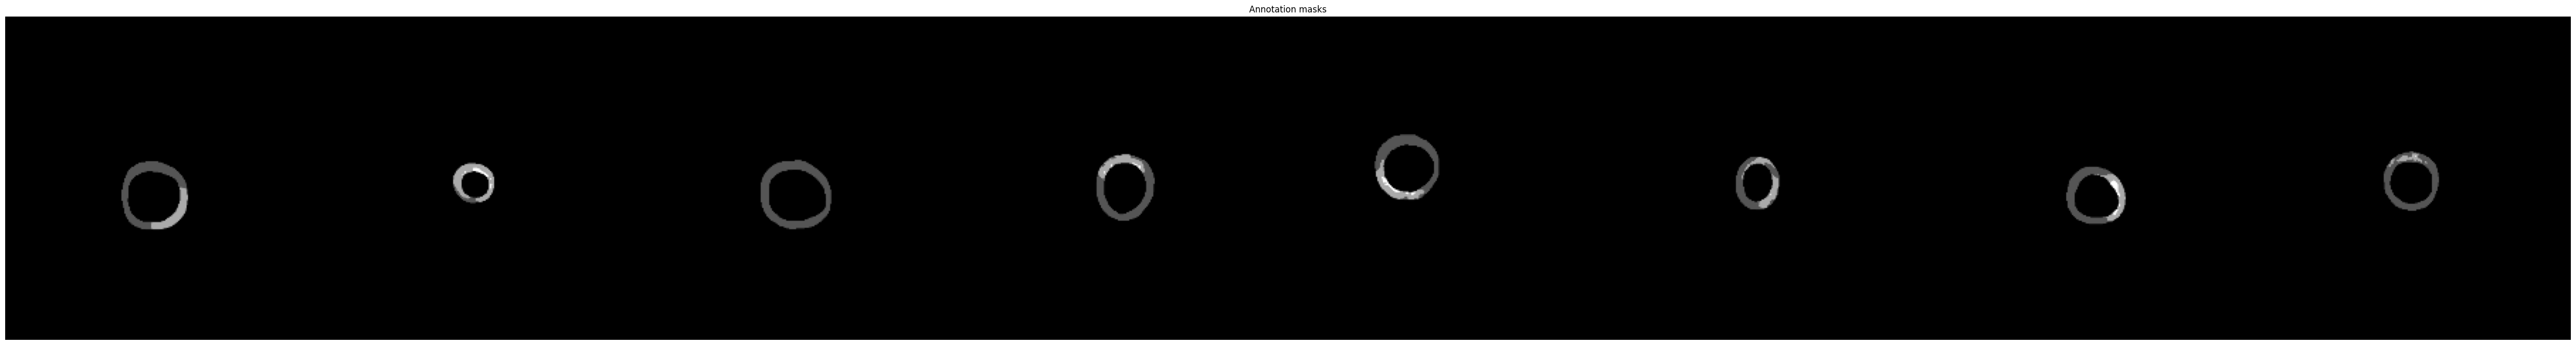

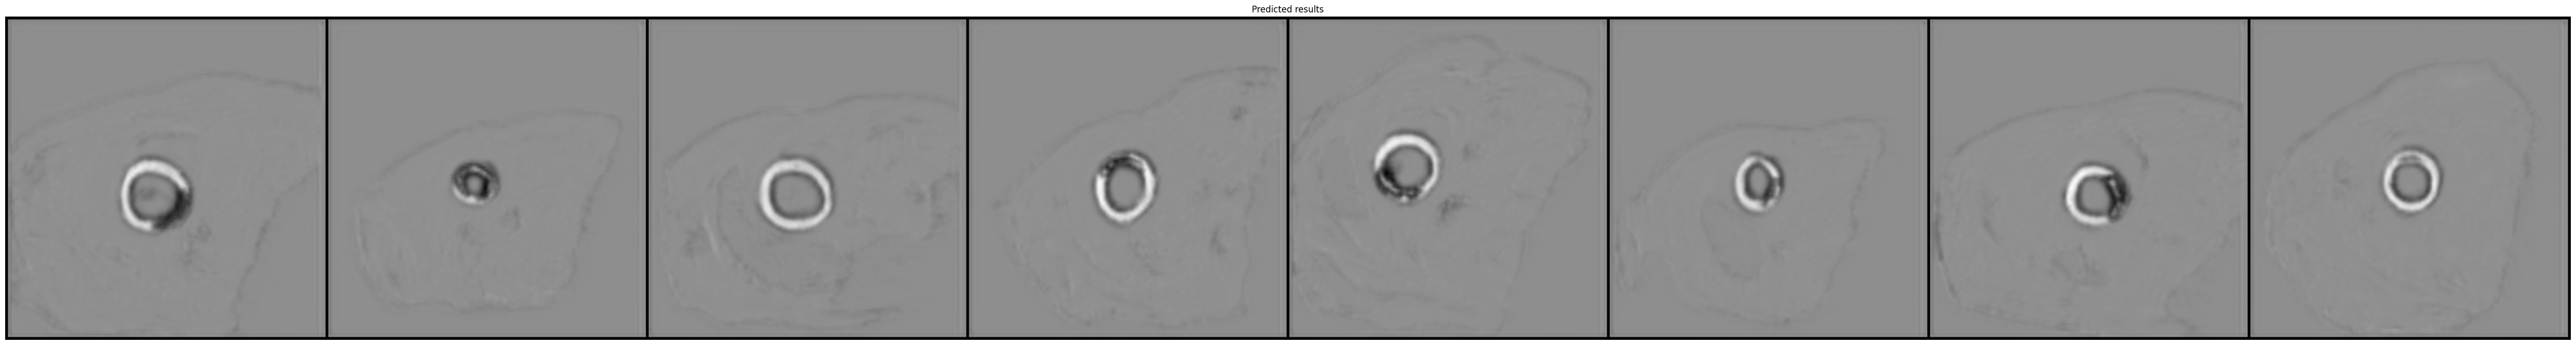

In [24]:
#Visualizations


plt.figure(figsize=(64,64))
plt.axis("off")
plt.title("Annotation masks")
plt.imshow(np.transpose(vutils.make_grid(mask[0:], padding=2, normalize=True).cpu(),(1,2,0)))
fig = plt.imshow(np.transpose(vutils.make_grid(mask[0:], padding=2, normalize=True).cpu(),(1,2,0)))
#fig.figure.savefig("/content/drive/My Drive/Internship_24_Ryan/Script/Brain MRI/exp_2_ground_label_seg/results/Fully S-multiclass-smploss-s1/Annotation masks V1.png", dpi=224)


# In[19]: show predicted results
# here we have to use mask_pre[0:,1].unsqueeze(1) - select 2nd channel as mask output and add one more dimension for 16,1,224,224 for image display

plt.figure(figsize=(64,64))
plt.axis("off")
plt.title("Predicted results")
plt.imshow(np.transpose(vutils.make_grid(mask_pre[0:,1].unsqueeze(1), padding=2, normalize=True).cpu(),(1,2,0)))
fig = plt.imshow(np.transpose(vutils.make_grid(mask_pre[0:,1].unsqueeze(1), padding=2, normalize=True).cpu(),(1,2,0)))
#fig.figure.savefig("/content/drive/My Drive/Internship_24_Ryan/Script/Brain MRI/exp_2_ground_label_seg/results/Fully S-multiclass-smploss-s1/Predicted results V1.png", dpi=224)


In [25]:
from types import NoneType

# other customized DICE calculation fuction - not in use
def single_dice_coef(y_true, y_pred_bin):
    # shape of y_true and y_pred_bin: (height, width)
    intersection = np.sum(y_true * y_pred_bin)
    if (np.sum(y_true) == 0) and (np.sum(y_pred_bin) == 0):
        return 1
    return (2 * intersection) / (np.sum(y_true) + np.sum(y_pred_bin))

# other customized DICE calculation fuction - not in use
def mean_dice_coef(y_true, y_pred_bin):
    # shape of y_true and y_pred_bin: (height, width, n_channels)
    channel_num = y_true.shape[-1]
    mean_dice_channel = 0.
    for j in range(channel_num):
        channel_dice = single_dice_coef(y_true[:, :, j], y_pred_bin[:, :, j])
        mean_dice_channel += channel_dice / (channel_num)
    return mean_dice_channel

# standard DICE calculation fuction
def dice_coef2(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    union = np.sum(y_true_f) + np.sum(y_pred_f)
    if union == 0:
        return 1
    intersection = np.sum(y_true_f * y_pred_f)
    score = 2. * intersection / union
    #print(score)
    return 2. * intersection / union



In [26]:
#Import libraries
from scipy.stats import logistic
import gc

#Define variables for average dice coefficient score
score_1 = 0
count = 0
i = 0
lst = []

#Define the total amount of accuracy for each of the labels and the count of each label for individual label accuracy
label_1 = 0
label_2 = 0
label_3 = 0
count_1 = 0
count_2 = 0
count_3 = 0


#Define testing dataset
LGE_path_test = '/content/drive/My Drive/Internship_24_Ryan/Heart/Data/test/LGE/'
Cine_path_test = '/content/drive/My Drive/Internship_24_Ryan/Heart/Data/test/Cine/'
mask_path_test = '/content/drive/My Drive/Internship_24_Ryan/Heart/Data/test/masks/'

test_set_phx = My_Dataset(LGE_path_test, Cine_path_test, mask_path_test, transform1=transforms_img, transform2=transforms_mask)
n_test = len(test_set_phx)
test_loader_phx = Data.DataLoader(dataset=test_set_phx,num_workers=0,batch_size=1,pin_memory=True)

#Calculate avg dice score and individual label dice score
for i, (LGE, Cine, mask, filename) in enumerate(test_loader_phx):


    shown_pred = np.zeros((224,224))

    #Send images and masks to GPU
    LGE = LGE.to(device=device,dtype=torch.float32)
    mask = mask.to(device=device,dtype=torch.float32)
    Cine = Cine.to(device=device,dtype=torch.float32)

    #Predict on images
    input = [LGE, Cine]

    with torch.no_grad():
        model_test.eval()
        pre = model_test(input)
        pred = torch.softmax(pre, dim = 1)



    if type(pred) != type(None) and type(mask) != type(None):
      img_score = 0
      for layer in range(3):

        #The model returns an output of shape (4,224,224), with each of the channels being one label's prediction. For example, pred[2] defines the area that the model thinks belongs to Label 2
        #However, the mask is shape (1,224,224), with the different labels simply having different values, with the area of Label 2 being all the pixels that have value 2
        #Label 0 is the background label, the non-disease label, so we do not use it in our evaluation of the dice score

        #Get the ground truth area of the label the for loop is currently on
        temp_mask = np.where(mask.cpu().numpy() == layer+1, 1, 0)

        #Each of the if statements allows a different threshold for each of the layers
          #Get the predicted area of the label the for loop is currently on
        temp_pred = np.where(pred[0][layer+1].cpu().numpy() > 0.5, 1, 0)

        #calculate dice score and add to sum
        score_temp = dice_coef2(temp_mask, temp_pred)
        img_score += score_temp

        #If the label is 1, add it to the dice score sum for layer 1 and add one to the number of files that have label 1
        #Continue for all labels

        #Remember that if layer == 0, that means the Label is 1
        #Label 0 is the background layer, and Label 1-3 are heart disease labels
        #The for loop goes through each label, so if the label the for loop is currently on satisfies one of the if statements, add that score to the label's score
        if layer == 0:
          label_1 += score_temp
          count_1 += 1
          pred_label_1 = np.where(pred[0][layer+1].cpu().numpy() > 0.5, 1, 0)
        elif layer == 1:
          label_2 += score_temp
          count_2 += 1
          pred_label_2 = np.where(pred[0][layer+1].cpu().numpy() > 0.5, 2, 0)
        elif layer == 2:
          label_3 += score_temp
          count_3 += 1
          pred_label_3 = np.where(pred[0][layer+1].cpu().numpy() > 0.5, 3, 0)



      #Divide the image score by 3 for each of the labels
      final_img_score = img_score/3

      #Add to list
      lst += [[final_img_score, [LGE, mask, Cine],    [pred_label_1, pred_label_2, pred_label_3]    ]]

      score_1 = score_1 + final_img_score
      count += 1
    else:
      print(i)


print("Dice Coefficient", score_1/count)
print("Label 1 score: ", label_1/count_1)
print("Label 2 score: ", label_2/count_2)
print("Label 3 score: ", label_3/count_3)

Dice Coefficient 0.764305250962217
Label 1 score:  0.8400223853005099
Label 2 score:  0.7117479176265696
Label 3 score:  0.7411454499595731


In [27]:
#Below code is for sorting the images and displaying them

In [28]:
from operator import itemgetter
sorted_lst = sorted(lst, key=itemgetter(0))
rounded_lst = [[round(pair[0], 3), pair[1]] for pair in sorted_lst]

In [29]:
sorted_lst[1][0]

0.47588652482269506

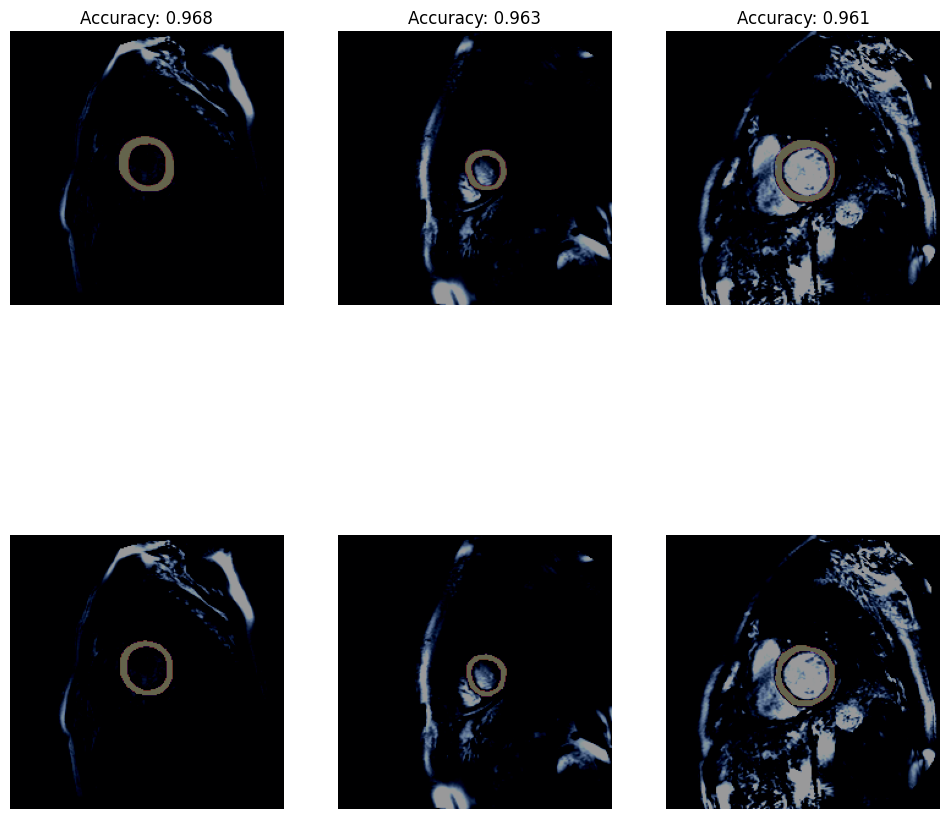

In [30]:
fig, axes = plt.subplots(2, 3, figsize=(12, 12))

for i in range(3):
  #change index here
  index = ((i+1) * -1 )

  LGE = sorted_lst[index][1][0] # here we load as RBG
  cine = sorted_lst[index][1][2] # here we load as RBG

  mask = sorted_lst[index][1][1] # here we load as RBG


  #print(np.max(mask.squeeze(0).cpu().numpy()))
  label_1_pred = sorted_lst[index][2][0]
  label_2_pred = sorted_lst[index][2][1]
  label_3_pred = sorted_lst[index][2][2]


  first_pred = np.add(label_1_pred, label_2_pred)
  pred = np.add(first_pred, label_3_pred)




  #axes.set_title("Ground truth")
  axes[0, i].imshow(LGE.squeeze(0).cpu().numpy().swapaxes(0,2))
  axes[0, i].imshow(mask.squeeze(0).cpu().numpy().swapaxes(0,2), alpha = 0.4, cmap = 'magma')
  axes[0, i].axis('off')  # Hide axis
  axes[0, i].set_title(f"Accuracy: {round(sorted_lst[index][0], 3)}")

  #axes[0].set_title("Ground Truth")

  #axes.set_title("Predictions")
  axes[1, i].imshow(LGE.squeeze(0).cpu().numpy().swapaxes(0,2))

  axes[1, i].imshow(pred.swapaxes(0,1), alpha = 0.4, cmap = 'magma')

  #axes[0, i].axis('off')  # Hide axis
  axes[1, i].axis('off')  # Hide axis


  #axes[0, i].imshow(pred.squeeze(0).cpu().numpy().swapaxes(0,2))
  #axes[0, i].axis('off')  # Hide axis
  #axes[i].set_title(f"Accuracy: {lst[inverse][0]}")

